In [1]:
import os
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

CSV_PATH = "education_policies.csv"
TRAIN_PATH = "train_policies.csv"
TEST_PATH = "test_policies.csv"

def generate_synthetic_policies(n=500):
    states = ["Karnataka","Maharashtra","Tamil Nadu","Uttar Pradesh","Delhi","Kerala","West Bengal","Gujarat","Rajasthan","Punjab"]
    sectors = ["Primary","Secondary","Higher Education","Vocational","Early Childhood"]
    target_groups = ["Students","Teachers","Rural Students","Urban Students","Women","Disadvantaged Groups","All"]
    statuses = ["Proposed","Implemented","Under Review","Pilot"]
    years = list(range(2015, 2026))
    stakeholders_list = [
        "Ministry of Education, Local NGOs",
        "State Education Department, Private Partners",
        "Teachers' Unions, Community Leaders",
        "Central Government, Donors",
        "EdTech Companies, Universities"
    ]
    funding_ranges = [(0.5,5),(5,20),(20,100),(0.1,0.5)]
    aspects = ["learning outcomes","infrastructure","teacher quality","digital access","early childhood development","vocational skills"]
    interventions = ["grants to schools","teacher training programs","digital device distribution","curriculum reform","scholarship schemes","public-private partnerships"]
    focuses = ["marginalized communities","gender equity","rural accessibility","urban inclusion","STEM education","literacy and numeracy"]
    secondary_aspects = ["community participation","governance","assessment quality","safety standards"]

    records = []
    for i in range(1, n+1):
        policy_id = f"P{1000+i}"
        title = f"{random.choice(['National','State','District'])} {random.choice(sectors)} Education Reform {random.randint(1,99)}"
        sector = random.choice(sectors)
        region = random.choice(states)
        year = random.choice(years)
        target_group = random.choice(target_groups)
        status = random.choice(statuses)
        funding = round(random.uniform(*random.choice(funding_ranges)), 2)
        stakeholders = random.choice(stakeholders_list)
        impact_score = round(random.uniform(0.1, 0.99), 3)
        summary = f"This policy aims to improve {random.choice(aspects)} in {sector} through {random.choice(interventions)} in {region}."
        goals = f"Increase reach by {random.randint(5,40)}% in {random.randint(1,5)} years."
        full_text = f"{summary} Goals: {goals}"

        records.append({
            "policy_id": policy_id,
            "title": title,
            "sector": sector,
            "region": region,
            "year": year,
            "target_group": target_group,
            "status": status,
            "funding_million_usd": funding,
            "stakeholders": stakeholders,
            "impact_score": impact_score,
            "summary": summary,
            "goals": goals,
            "full_text": full_text
        })

    return pd.DataFrame(records)

def preprocess(df):
    df = df.copy()
    df["text_for_nlp"] = (df["title"].astype(str) + ". " + df["full_text"].astype(str) + ". Stakeholders: " + df["stakeholders"].astype(str)).str.lower()
    return df

# Generate data
if not os.path.exists(CSV_PATH):
    df = generate_synthetic_policies(500)
    df.to_csv(CSV_PATH, index=False)
else:
    df = pd.read_csv(CSV_PATH)

# Preprocess and split
df = preprocess(df)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)

train_df.to_csv(TRAIN_PATH, index=False)
test_df.to_csv(TEST_PATH, index=False)

print(f"Data prepared: {len(train_df)} train, {len(test_df)} test.")


Data prepared: 400 train, 100 test.


In [2]:
# model

In [7]:
import joblib
import pandas as pd
import pennylane as qml
from pennylane import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

MODEL_PATH = "policy_vectorizer.pkl"
MATRIX_PATH = "policy_tfidf_matrix.pkl"

# Load train and full dataset
train_df = pd.read_csv("train_policies.csv")
full_df = pd.read_csv("education_policies.csv")

# --- Preprocess function ---
def preprocess(df):
    df = df.copy()
    df["text_for_nlp"] = (df["title"].astype(str) + ". " +
                          df["full_text"].astype(str) + ". Stakeholders: " +
                          df["stakeholders"].astype(str)).str.lower()
    return df

# Apply preprocessing
train_df = preprocess(train_df)
full_df = preprocess(full_df)

# --- Train TF-IDF ---
vectorizer = TfidfVectorizer(max_features=8, ngram_range=(1, 2))  # Reduced to 8 features for quantum encoding (2^3 qubits)

vectorizer.fit(train_df["text_for_nlp"])

# Transform full data
tfidf_matrix = vectorizer.transform(full_df["text_for_nlp"]).toarray()

# --- Quantum Amplitude Encoding ---
# Normalize TF-IDF vectors (required for amplitude encoding)
norms = np.linalg.norm(tfidf_matrix, axis=1, keepdims=True)
norms[norms == 0] = 1  # Avoid division by zero
normalized_vectors = tfidf_matrix / norms

# Define a 3-qubit quantum device (since 2^3 = 8 features)
n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits)

# Define quantum feature encoding circuit
@qml.qnode(dev)
def quantum_encode(vector):
    # Embed TF-IDF vector into amplitude of quantum state
    qml.AmplitudeEmbedding(vector, wires=range(n_qubits), normalize=True)
    # Optional: simple feature mixing layer
    qml.BasicEntanglerLayers(np.random.random((2, n_qubits)), wires=range(n_qubits))
    # Return final quantum state
    return qml.state()

# Encode all TF-IDF rows into quantum states
quantum_states = []
for vec in normalized_vectors:
    state = quantum_encode(vec)
    quantum_states.append(state)

quantum_states = np.array(quantum_states)

# --- Save Model and Data ---
joblib.dump(vectorizer, MODEL_PATH)
joblib.dump(
    {
        "quantum_states": quantum_states,
        "tfidf_matrix": tfidf_matrix,
        "normalized_vectors": normalized_vectors,
        "df": full_df
    },
    MATRIX_PATH
)

print(f"✅ Quantum TF-IDF encoding complete and saved to {MODEL_PATH} and {MATRIX_PATH}")


✅ Quantum TF-IDF encoding complete and saved to policy_vectorizer.pkl and policy_tfidf_matrix.pkl


TF-IDF matrix shape: (500, 8), Sparsity: 95.70%
Top 20 words/phrases by TF-IDF importance:
and: 254.67
to: 226.47
education: 184.33
reform: 124.55
state: 120.85
stakeholders: 109.32
education reform: 109.32
goals: 109.32


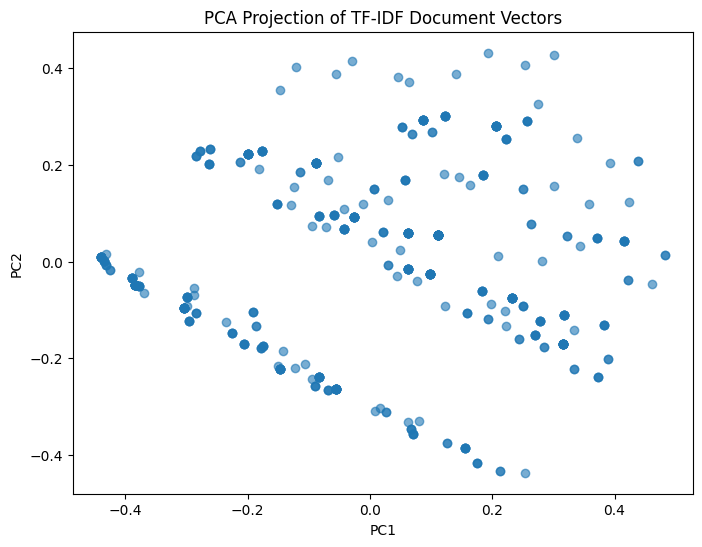

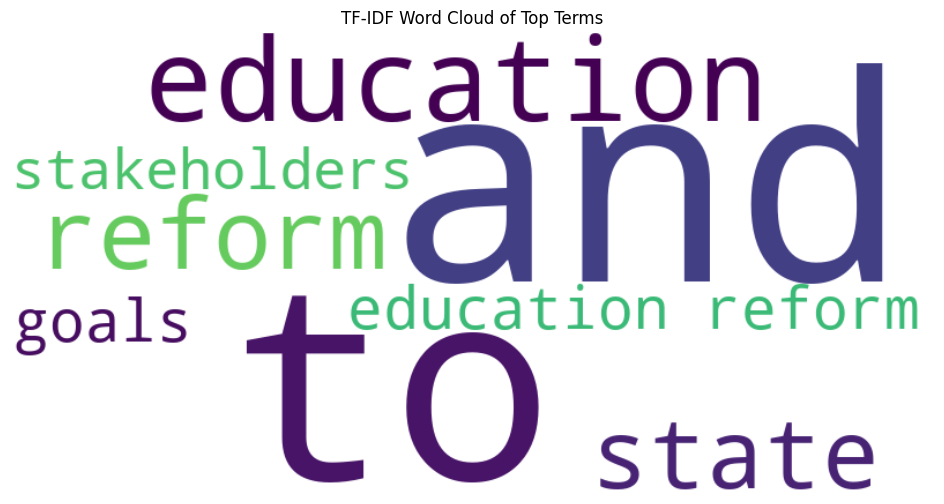

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from wordcloud import WordCloud

# --------------------------
# 1. Sparsity
# --------------------------
sparsity = 100.0 * (np.count_nonzero(tfidf_matrix) / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1]))
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}, Sparsity: {sparsity:.2f}%")

# --------------------------
# 2. Top 20 words in vocabulary
# --------------------------
feature_names = np.array(vectorizer.get_feature_names_out())
tfidf_sum = np.sum(tfidf_matrix, axis=0).flatten()
top_indices = tfidf_sum.argsort()[::-1][:min(20, len(feature_names))]  # Ensure we don't exceed available features
print("Top 20 words/phrases by TF-IDF importance:")
for word, score in zip(feature_names[top_indices], tfidf_sum[top_indices]):
    print(f"{word}: {score:.2f}")

# --------------------------
# 3. PCA projection (2D) of documents
# --------------------------
pca = PCA(n_components=2)
reduced = pca.fit_transform(tfidf_matrix)  # Already a NumPy array

plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.6)
plt.title("PCA Projection of TF-IDF Document Vectors")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# --------------------------
# 4. Word cloud of top words
# --------------------------
top_words_dict = {feature_names[i]: tfidf_sum[i] for i in range(len(feature_names))}
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words_dict)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("TF-IDF Word Cloud of Top Terms")
plt.show()

In [5]:
# Load model

In [15]:
import textwrap
import joblib
import pennylane as qml
from pennylane import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

MODEL_PATH = "policy_vectorizer.pkl"
MATRIX_PATH = "policy_tfidf_matrix.pkl"

# Load the vectorizer and data
vectorizer = joblib.load(MODEL_PATH)
data = joblib.load(MATRIX_PATH)

# Access the correct keys
tfidf_matrix = data["tfidf_matrix"]  # Updated key from "matrix" to "tfidf_matrix"
df = data["df"]
normalized_vectors = data["normalized_vectors"]  # For quantum kernel

# Quantum device setup (3 qubits for 8 features)
n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum feature map (amplitude encoding)
def feature_map(vec):
    qml.AmplitudeEmbedding(vec, wires=range(n_qubits), normalize=True)
    qml.BasicEntanglerLayers(np.random.random((2, n_qubits)), wires=range(n_qubits))

# Quantum kernel circuit
@qml.qnode(dev)
def kernel_circuit(v1, v2):
    feature_map(v1)
    qml.adjoint(feature_map)(v2)
    return qml.probs(wires=range(n_qubits))

def answer_query_quantum(query, top_k=3):
    # Transform query to TF-IDF vector
    query_tfidf = vectorizer.transform([query.lower()]).toarray()[0]
    # Normalize query vector
    norm = np.linalg.norm(query_tfidf)
    query_vec = query_tfidf / norm if norm > 0 else np.zeros_like(query_tfidf)
    
    # Compute quantum kernel similarities
    sims = np.array([kernel_circuit(query_vec, normalized_vectors[i])[0] for i in range(normalized_vectors.shape[0])])
    top_idx = sims.argsort()[::-1][:top_k]

    # Print results
    print(f"\n🔎 Query: {query}")
    for idx in top_idx:
        row = df.iloc[idx]
        snippet = textwrap.shorten(row["full_text"], width=250, placeholder="...")
        print(f"\n📌 {row['title']} ({row['policy_id']}) | Quantum Similarity={sims[idx]:.3f}")
        print(f"Region: {row['region']} | Year: {row['year']} | Status: {row['status']}")
        print(f"Summary: {snippet}")

# Example query
answer_query_quantum("primary education policy", top_k=3)



🔎 Query: primary education policy

📌 District Higher Education Education Reform 98 (P1468) | Quantum Similarity=0.641
Region: Gujarat | Year: 2025 | Status: Proposed
Summary: This policy aims to improve digital access in Higher Education by providing scholarship schemes across Gujarat. It focuses on STEM education. Goals: Introduce technology-enabled platforms for learning continuity, improve assessment methods, and...

📌 National Early Childhood Education Reform 94 (P1492) | Quantum Similarity=0.593
Region: Karnataka | Year: 2018 | Status: Proposed
Summary: This policy aims to improve early childhood development in Higher Education by providing public-private partnerships across Karnataka. It focuses on STEM education. Goals: Increase early childhood development score by 13% within 3 years and reduce...

📌 National Early Childhood Education Reform 30 (P1248) | Quantum Similarity=0.585
Region: Uttar Pradesh | Year: 2015 | Status: Proposed
Summary: This policy aims to improve infrastru

In [25]:
import joblib
import pennylane as qml
from pennylane import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings

# Suppress RuntimeWarning for cleaner output (optional)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# File paths
MODEL_PATH = "policy_vectorizer.pkl"
MATRIX_PATH = "policy_tfidf_matrix.pkl"

# Load saved models
vectorizer = joblib.load(MODEL_PATH)
data = joblib.load(MATRIX_PATH)
tfidf_matrix = data["tfidf_matrix"]
full_df = data["df"]
normalized_vectors = data["normalized_vectors"]

# Quantum device setup (3 qubits for 8 features)
n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum feature map (amplitude encoding)
def feature_map(vec):
    # Check for zero-norm vector
    norm = np.linalg.norm(vec)
    if norm == 0:
        # Return a default vector (e.g., uniform superposition)
        vec = np.ones_like(vec) / np.sqrt(len(vec))
    qml.AmplitudeEmbedding(vec, wires=range(n_qubits), normalize=True)
    qml.BasicEntanglerLayers(np.random.random((2, n_qubits)), wires=range(n_qubits))

# Quantum kernel circuit
@qml.qnode(dev)
def kernel_circuit(v1, v2):
    feature_map(v1)
    qml.adjoint(feature_map)(v2)
    return qml.probs(wires=range(n_qubits))

# Recompute normalized vectors with stricter zero-norm handling
norms = np.linalg.norm(tfidf_matrix, axis=1, keepdims=True)
norms[norms == 0] = 1  # Avoid division by zero
normalized_vectors = tfidf_matrix / norms

# Verify and fix zero-norm vectors for quantum encoding
for i, vec in enumerate(normalized_vectors):
    if np.all(vec == 0):
        print(f"Warning: Zero-norm vector detected at index {i}. Replacing with uniform vector.")
        normalized_vectors[i] = np.ones_like(vec) / np.sqrt(len(vec))

# --------------------------
# Quantum query function
# --------------------------
def query_policy_quantum(question, top_k=3):
    """
    Returns top_k matching policies for the input question/query using quantum kernel.
    """
    # Preprocess the query
    query_text = question.lower()
    
    # Vectorize query
    query_tfidf = vectorizer.transform([query_text]).toarray()[0]
    
    # Normalize query vector
    norm = np.linalg.norm(query_tfidf)
    query_vec = query_tfidf / norm if norm > 0 else np.ones_like(query_tfidf) / np.sqrt(len(query_tfidf))
    
    # Compute quantum kernel similarities
    sims = []
    for i, vec in enumerate(normalized_vectors):
        try:
            sim = kernel_circuit(query_vec, vec)[0]
            sims.append(sim)
        except Exception as e:
            print(f"Error computing kernel for document {i}: {e}. Skipping.")
            sims.append(0.0)  # Assign zero similarity for failed computations
    
    sims = np.array(sims)
    
    # Get top k indices
    top_indices = sims.argsort()[::-1][:top_k]
    
    # Return policy info
    results = []
    for idx in top_indices:
        row = full_df.iloc[idx]
        results.append({
            "title": row["title"],
            "stakeholders": row["stakeholders"],
            "similarity": float(sims[idx])
        })
    return results

# --------------------------
# Demo usage
# --------------------------
question = "How are teacher trainings implemented in rural schools?"
top_matches = query_policy_quantum(question, top_k=3)

for i, res in enumerate(top_matches, 1):
    print(f"{i}. {res['title']} (Stakeholders: {res['stakeholders']}, Similarity: {res['similarity']:.2f})")


1. State Vocational Education Reform 62 (Stakeholders: Teachers' Unions, Community Leaders, Similarity: 0.98)
2. State Primary Education Reform 94 (Stakeholders: Central Government, Donors, Similarity: 0.92)
3. State Primary Education Reform 40 (Stakeholders: Teachers' Unions, Community Leaders, Similarity: 0.92)
